# Color Gradient Lattice Boltzman Method Simulation

In this setup, we simulate interaction between 2 fluids.

First fluid is spread across a rectangular grid.

Second fluid is present as a drop in the center of the grid.

There's a wall (obstacle) on both left and right sides of the grid.

## Installing dependencies and Importing modules

In [ ]:
# Installing dependencies for this notebook
%pip install einops moviepy proglog scikit-image

In [2]:
import jax.numpy as jnp
from einops import rearrange
import numpy as np

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [3]:
from cglbm.lbm import grid_eq_dist, eq_dist_phase_field
from cglbm.simulation import multi_step_simulation
from cglbm.environment import State, System

In [4]:
# from jax import config


# config.update("jax_debug_nans", True)
# config.update("jax_enable_x64", True)

## Simulation Setup

### Loading pre-defined environment

In [5]:
from cglbm.test_utils import load_config

system = load_config("params.ini")

### Initial conditions of simulation

In [6]:
LX = system.LX
LY = system.LY
grid_shape = (LX, LY)

phase_field = jnp.zeros(grid_shape)

center = (LX/2, LY/2)
radius = system.drop_radius
Y, X = jnp.meshgrid(jnp.arange(LY), jnp.arange(LX))


### Initializing drop

In [7]:
distanceFromCenter = jnp.sqrt((X - center[0]) ** 2 + (Y - center[1]) ** 2)

phase_field = 0.5 * (1.0 + jnp.tanh((distanceFromCenter - radius) * 2.0 / system.width))

### Initializing Density, Velocity, Pressure

In [8]:
rho = system.density_one * phase_field + system.density_two * (1.0 - phase_field)
pressure = jnp.full(grid_shape, system.ref_pressure)

u_x = -system.uWallX + (Y - 2.5) * 2 * system.uWallX / (LY - 6)
u_y = jnp.zeros(grid_shape)
u = rearrange(jnp.stack([u_x, u_y]), "x i j -> i j x") #.transpose(1, 2, 0)

### Defining Obstacle

In [9]:
obs = jnp.zeros(grid_shape, dtype=bool)
obs_velX = jnp.zeros(grid_shape)
obs_velY = jnp.zeros(grid_shape)

# TODO: Find another way to set the obstacle
for i in range(system.LX):
    obs = obs.at[i, [0, 1, 2, -3, -2, -1]].set(True)
    obs_velX = obs_velX.at[i, [-3, -2, -1]].set(system.uWallX)
    obs_velX = obs_velX.at[i, [0, 1, 2]].set(-system.uWallX)

obs_vel = rearrange(jnp.stack([obs_velX, obs_velY]), "x i j -> i j x")

### Plotting obstacle and phase_field

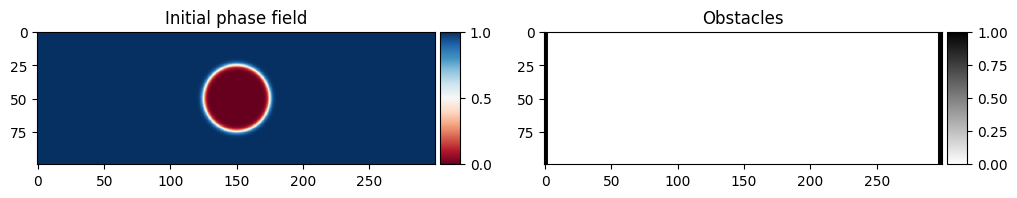

In [31]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

im0 = axs[0].imshow(phase_field, cmap='RdBu')
axs[0].set_title("Initial phase field")

divider = make_axes_locatable(axs[0])
cax0 = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im0, cax=cax0, orientation='vertical')

im1 = axs[1].imshow(obs, cmap='binary')
axs[1].set_title("Obstacles")

divider = make_axes_locatable(axs[1])
cax1 = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im1, cax=cax1, orientation='vertical')

### Initialising f and N

In [11]:
f = eq_dist_phase_field(system.cXYs, system.weights, phase_field, jnp.zeros((LX, LY, 2)))
N = grid_eq_dist(system.cXYs, system.weights, system.phi_weights, pressure, jnp.zeros((LX, LY, 2)))

### Initialising state of the simulation

In [12]:
state = State(
    rho=rho,
    pressure=pressure,
    u=u,
    obs=obs,
    obs_velocity=obs_vel,
    f=f,
    N=N
)

## Running the Simulation

In [13]:
nr_iter = 2000
nr_snapshots = 100
final_step = multi_step_simulation(system, state, nr_iter, nr_snapshots)

### Benchmark

In [14]:
# %timeit multi_step_simulation(system, state, 1000, 100)

## Visualizations

### Calculating vorticity

In [15]:
import matplotlib.pyplot as plt
import matplotlib.colors as clr
import skimage.filters

ux_final, uy_final = rearrange(final_step["u"], "t i y x -> x t i y")

# ux_final[:,obstacle] = 0
# uy_final[:,obstacle] = 0
vorticity = (
    np.roll(ux_final, -1, axis=1) - np.roll(ux_final, 1, axis=1)
) - (
    np.roll(uy_final, -1, axis=2) - np.roll(uy_final, 1, axis=2))

### Visualisation phase field from each iteration

In [16]:
f_final = final_step["f"]

phase_field_final = np.einsum("tkij->tij", f_final)

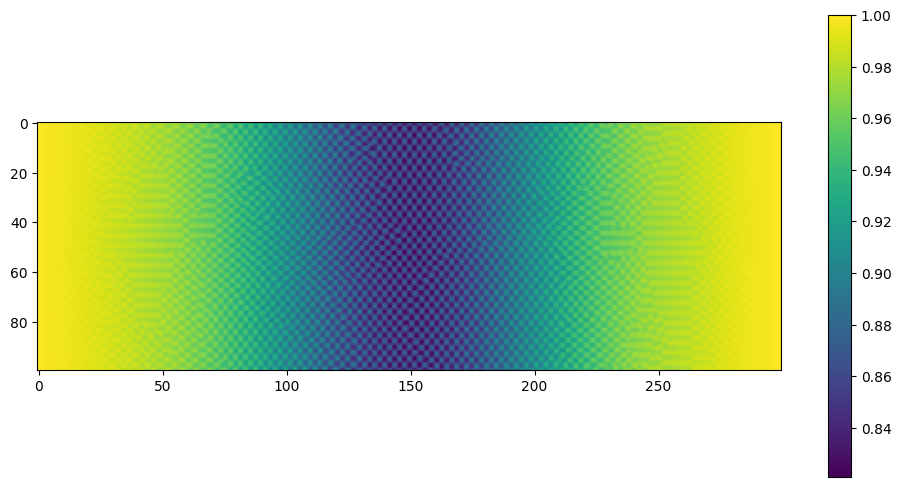

In [17]:
n = 60

fig, axs = plt.subplots(1, 1, figsize=(12, 6))

plt.imshow(phase_field_final[n,:,:])
plt.colorbar()

### Stream Plot

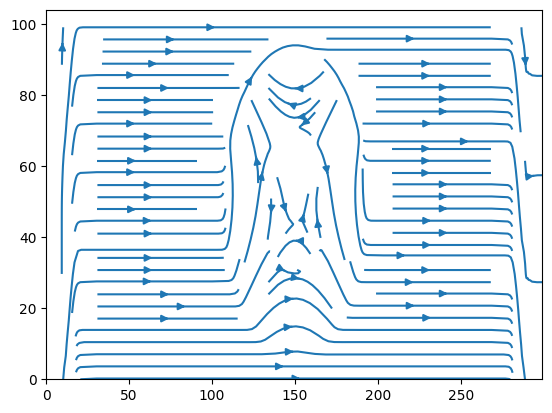

In [18]:
frame = 1
xsize = ux_final[frame].shape[0]
ysize = ux_final[frame].shape[1]

Y, X = np.meshgrid(np.arange(ysize), np.arange(xsize))
plt.streamplot(Y, X, ux_final[frame], uy_final[frame])

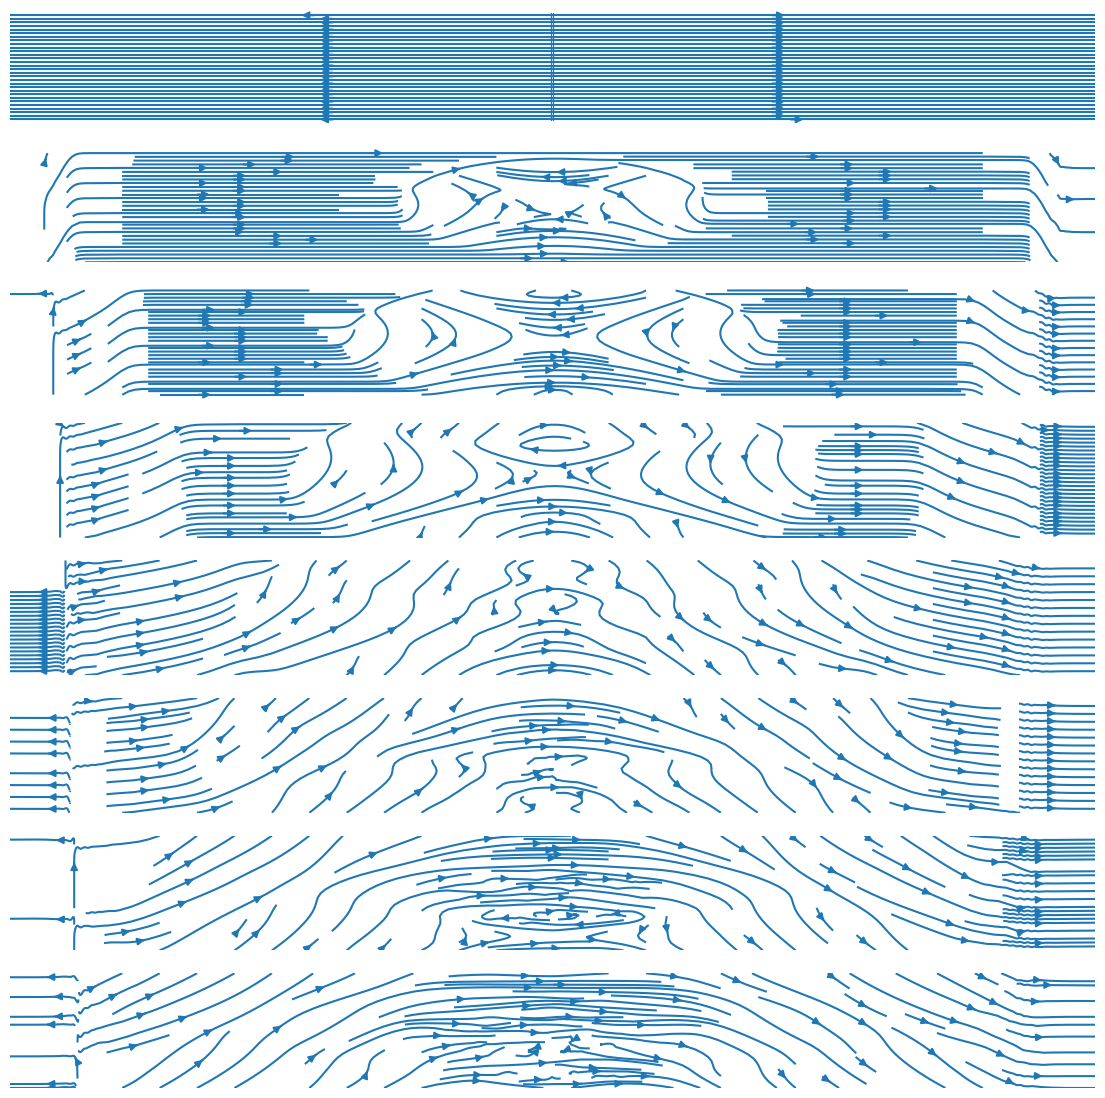

In [19]:
n = 8
samples = 100

xsize = ux_final[0].shape[0]
ysize = ux_final[0].shape[1]
Y, X = np.meshgrid(np.arange(ysize), np.arange(xsize))

fig, axes = plt.subplots(n, 1, figsize=(14, 14))
[ax.axis('off') for ax in axes]

# axes[0].cmap
# fig.colorbar()
for i in range(min(n, nr_snapshots)):
    axes[i].streamplot(Y, X, ux_final[i], uy_final[i])


### Quiver Plot

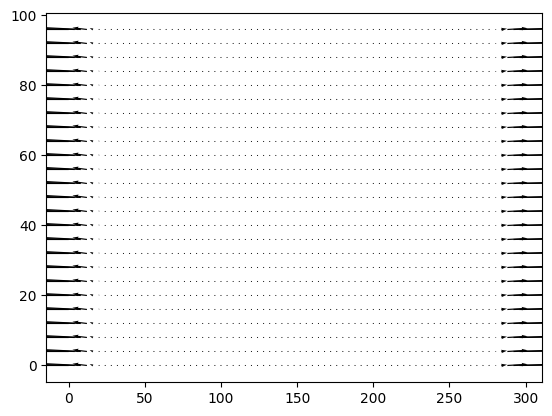

In [20]:
szx = LX
szy = LY
timestep = 10

# Plotting all the arrows will be messy so we are sampling one in every 16 points
skipx = 4
skipy = 4
x = np.arange(0,szx-1,skipx)
y = np.arange(0,szy-1,skipy)

yy, xx = jnp.meshgrid(y, x)

u = ux_final[timestep][:szx:skipx,:szy:skipy]
v = uy_final[timestep][:szx:skipx,:szy:skipy]

plt.quiver(yy, xx, u, v)

### Vorticity Plot

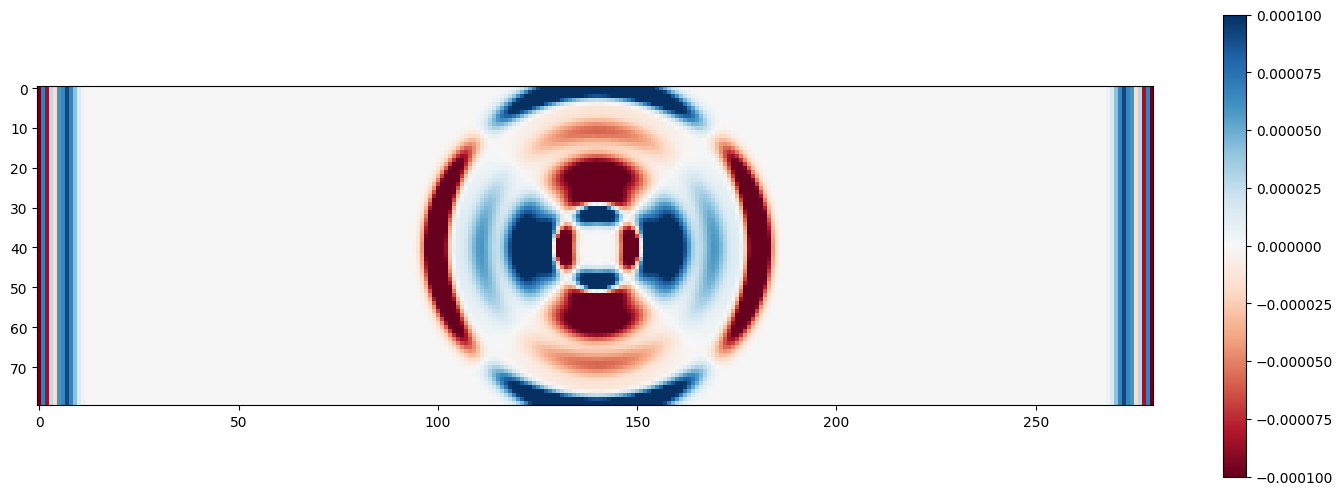

In [21]:
plt.figure(figsize=(18, 6))

frame = vorticity[1]

plt.imshow(frame[10:-10, 10:-10], cmap='RdBu')
plt.colorbar()
plt.clim(-.0001, .0001)

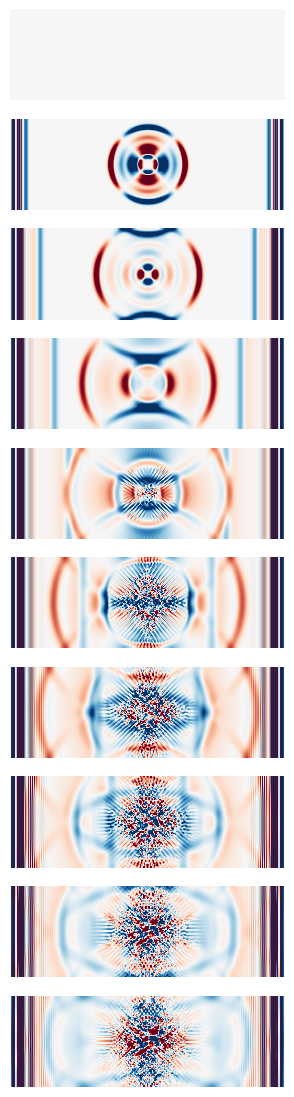

In [22]:
n = 10
samples = 100
fig, axes = plt.subplots(n, 1, figsize=(14, 14))
[ax.axis('off') for ax in axes]

# axes[0].cmap
# fig.colorbar()
axes[0].imshow(vorticity[0], cmap='RdBu', vmin=-0.0001, vmax=0.0001)
for i in range(min(n-1, len(vorticity)-1)):
    axes[i+1].imshow(vorticity[i + 1], cmap='RdBu', vmin=-0.0001, vmax=0.0001)

## Creating video out of snapshots

In [23]:
import matplotlib.cm
import matplotlib.colors
from PIL import Image

def make_images(data, cmap='RdBu', vmax=None):
    images = []
    for frame in data:
        if vmax is None:
            this_vmax = np.max(abs(frame))
        else:
            this_vmax = vmax
        norm = matplotlib.colors.Normalize(vmin=-this_vmax, vmax=this_vmax)
        mappable = matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap)
        rgba = mappable.to_rgba(frame, bytes=True)
        image = Image.fromarray(rgba, mode='RGBA')
        images.append(image)
    return images

def save_movie(images, path, duration=100, loop=0, **kwargs):
    images[0].save(path, save_all=True, append_images=images[1:],
                 duration=duration, loop=loop, **kwargs)


In [24]:
from functools import partial
import proglog
import skimage.filters
from moviepy.editor import ImageSequenceClip

# Show Movie
proglog.default_bar_logger = partial(proglog.default_bar_logger, None)

In [ ]:
# Video from vorticity plots
images = make_images(vorticity, vmax=0.0001)
ImageSequenceClip([np.array(im) for im in images], fps=10).ipython_display()

In [26]:
# save_movie(images,'wave_movie.gif', duration=[2000]+[200]*(len(images)-2)+[2000])

In [ ]:
# Video from phase field 
phase_images = make_images(phase_field_final, cmap='RdBu')
ImageSequenceClip([np.array(im) for im in phase_images], fps=10).ipython_display()